Fraud detection problems is one of the top priorities for banks and financial institutions.

**Import the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,classification_report
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from sklearn.model_selection import StratifiedKFold

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')


['creditcard.csv']


**Exploratery Data Analysis**

**Import the dataset**

**Where variables from V1-V28 is generated by PCA reduction technique.**

In [2]:
#import the training dataset
cc_df=pd.read_csv('../input/creditcard.csv')
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Shape of the dataset**

In [3]:
#Shape of the dataset
cc_df.shape

(284807, 31)

**Target classes count**

0    284315
1       492
Name: Class, dtype: int64


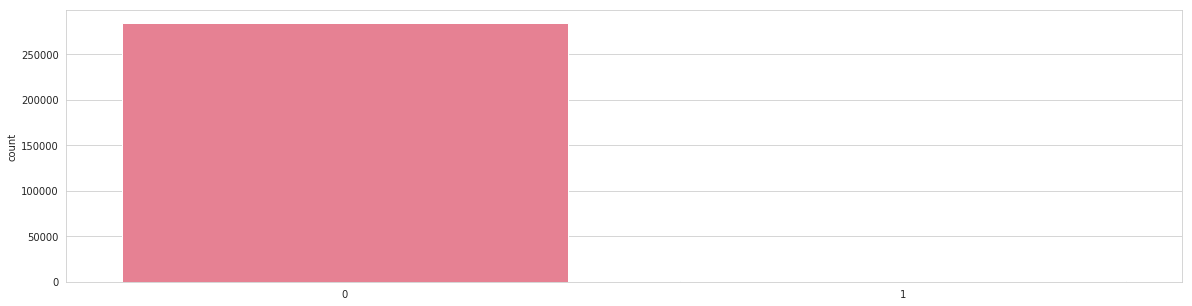

In [4]:
#count of target classes
print(cc_df['Class'].value_counts())
#count for target classes
fig,ax=plt.subplots(figsize=(20,5))
sns.countplot(cc_df.Class.values,palette='husl')

**Typecasting of attributes**

In [5]:
#Typecasting the attributes

def type_casting(attributes):

    for var in attributes:
        cc_df[var]=cc_df[var].astype('int64')
attributes=cc_df.columns[0:30].values
type_casting(attributes)

cc_df.dtypes

Time      int64
V1        int64
V2        int64
V3        int64
V4        int64
V5        int64
V6        int64
V7        int64
V8        int64
V9        int64
V10       int64
V11       int64
V12       int64
V13       int64
V14       int64
V15       int64
V16       int64
V17       int64
V18       int64
V19       int64
V20       int64
V21       int64
V22       int64
V23       int64
V24       int64
V25       int64
V26       int64
V27       int64
V28       int64
Amount    int64
Class     int64
dtype: object

**Normalize the class labels**

In [6]:
#Percentage of target classes count
cc_df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

We can observed that 99.8% of data is non fraud credit card transaction and 0.17% of data is fraud transaction.Dataset is highly imbalanced.

**Distribution of attributes**

<Figure size 432x288 with 0 Axes>

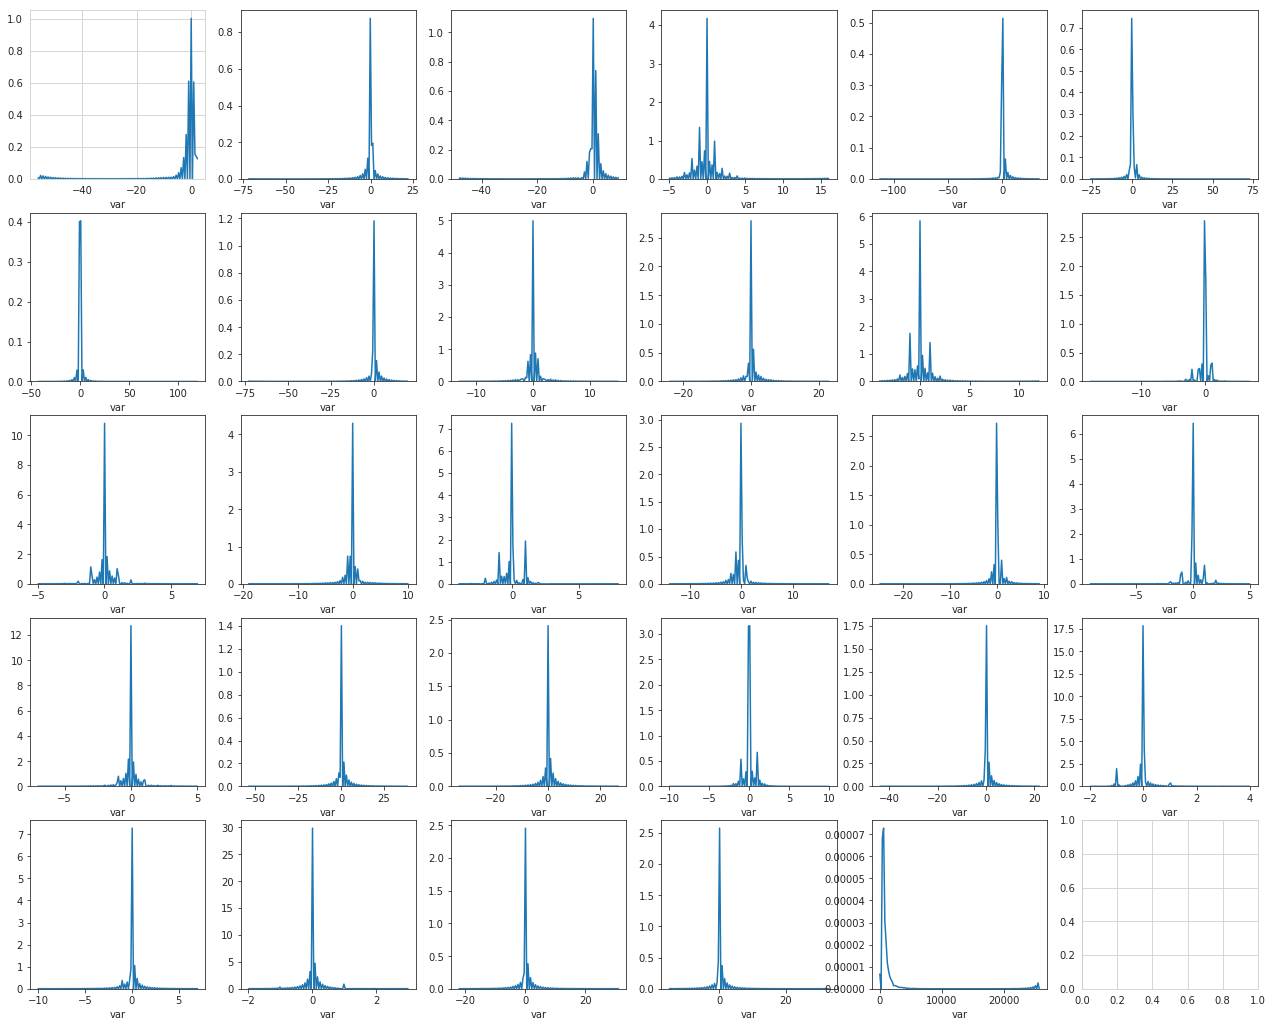

CPU times: user 5.96 s, sys: 3.19 s, total: 9.15 s
Wall time: 5.54 s


In [7]:
%%time
#Distribution of attributes
attributes=cc_df.columns.values[1:30]
def plot_attribute_distribution(attributes):
    i=0
    sns.set_style('whitegrid')
    
    fig=plt.figure()
    ax=plt.subplots(5,6,figsize=(22,18))
    
    for var in attributes:
        i+=1
        plt.subplot(5,6,i)
        sns.distplot(cc_df[var],hist=False)
        plt.xlabel('var',)
        sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.show()

plot_attribute_distribution(attributes)

**Normalization of Amount variable**

In [8]:
ss=StandardScaler()
amount=np.array(cc_df['Amount']).reshape(-1,1)
amount_ss=ss.fit_transform(amount)
amount_df=pd.DataFrame(amount_ss,columns=['Amount'])
amount_df.head()

,Amount
0,0.244376
1,-0.343275
2,1.159834
3,0.140438
4,-0.075434


In [9]:
cc_df=cc_df.drop(['Amount'],axis=1)
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0,-1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,-1,-1,1,0,0,1,0,0,-1,0,0,0,0,0,2,-2,1,0,-2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,1,0,0,-1,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,-1,0,0,0,0,0
4,2,-1,0,1,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Adding normalized Amount variable to training data**

In [10]:
cc_df['Amount']=amount_df
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0,-1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.244376
1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.343275
2,1,-1,-1,1,0,0,1,0,0,-1,0,0,0,0,0,2,-2,1,0,-2,0,0,0,0,0,0,0,0,0,0,1.159834
3,1,0,0,1,0,0,1,0,0,-1,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,-1,0,0,0,0,0,0.140438
4,2,-1,0,1,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.075434


**Split the dataset by stratifiedKFold cross validator**

In [11]:
%%time
#Training data
X=cc_df.drop(['Time','Class'],axis=1)
Y=cc_df['Class']
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
for train_index,test_index in cv.split(X,Y):
    X_train, X_test=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=Y.iloc[train_index], Y.iloc[test_index]
print('Shape of X_train :',X_train.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_train :',y_test.shape)
print('Shape of y_test :',y_test.shape)


Shape of X_train : (227846, 29)
Shape of X_test: (56961, 29)
Shape of y_train : (56961,)
Shape of y_test : (56961,)
CPU times: user 340 ms, sys: 492 ms, total: 832 ms
Wall time: 833 ms


**Training the lgbm model**

In [12]:
#training the model
lgb_train=lgb.Dataset(X_train,y_train)
lgb_train

**Choosing the hyperparameters**

In [13]:
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'boost_from_average':True, 
          'nthread': 12,
          'num_leaves': 100,
          'learning_rate': 0.05,
          'max_bin': 1000,      #default 255
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5, #>0
          'min_child_weight': 1,
          'min_child_samples': 5,
          'is_unbalance':True,
          'metric' : 'auc',
          }


**Training the model**

In [14]:
num_round=5000
lgbm= lgb.train(params,lgb_train,num_round,valid_sets=[lgb_train],verbose_eval=200,early_stopping_rounds = 2000)
lgbm

Training until validation scores don't improve for 2000 rounds.
[200]	training's auc: 0.999724
[400]	training's auc: 0.999859
[600]	training's auc: 0.999909
[800]	training's auc: 0.99991
[1000]	training's auc: 0.99991
[1200]	training's auc: 0.99991
[1400]	training's auc: 0.99991
[1600]	training's auc: 0.99991
[1800]	training's auc: 0.99991
[2000]	training's auc: 0.99991
[2200]	training's auc: 0.99991
[2400]	training's auc: 0.99991
[2600]	training's auc: 0.99991
Early stopping, best iteration is:
[637]	training's auc: 0.99991


**Model performance on test data**

In [15]:
#predict the model
lgbm_predict_prob=lgbm.predict(X_test,random_state=42,num_iteration=lgbm.best_iteration)
lgbm_predict=np.where(lgbm_predict_prob>=0.5,1,0)
print(lgbm_predict)

[0 0 0 ... 0 0 0]


plot feature importance

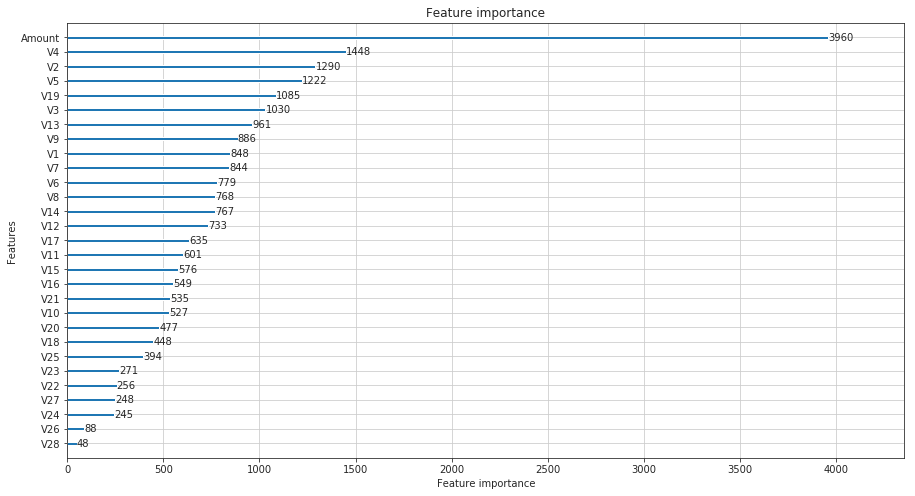

In [16]:
lgb.plot_importance(lgbm,max_num_features=29,importance_type="split",figsize=(15,8))

Plot the confusion matrix

[[56796    67]
 [   27    71]]


<Figure size 432x288 with 0 Axes>

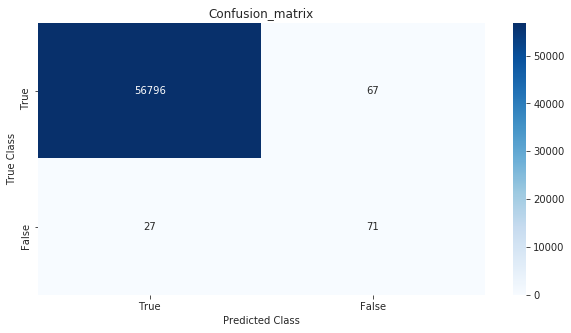

In [17]:
plt.figure()
cm=confusion_matrix(y_test,lgbm_predict)
print(cm)
labels=['True','False']
plt.figure(figsize=(10,5))
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,cmap='Blues',vmin=0.2,annot=True,fmt='d')
plt.title('Confusion_matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


**Classification report**

In [18]:
print(classification_report(y_test,lgbm_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.51      0.72      0.60        98

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.76      0.86      0.80     56961
weighted avg       1.00      1.00      1.00     56961



**Submission**

In [19]:
sub_df=pd.DataFrame(data=lgbm_predict,columns=['predicted_Class'])
sub_df.to_csv('submission.csv',index=False)
